In [1]:
import os, sys
os.chdir('/home/seigyo/Documents/pytorch/brain_decoder')
sys.path.append(os.pardir)
import numpy as np
from numpy.random import RandomState
import torch
from torch import nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch import optim
import mne
from mne.io import concatenate_raws
from mymodule.utils import data_loader, evaluator
from mymodule.trainer import Trainer
from sklearn.utils import shuffle
from tensorboardX import SummaryWriter
from load_data import get_data, get_data_multi, get_crops, get_crops_multi

In [4]:
X_crop, y_crop, _, _ = get_crops_multi(sub_id_range=[1, 10], event_code=[6,10,14],
                                 t=[0, 4.0], filter=[0.5,36],
                                 time_window=1.0, time_step=1)
print(X_crop.shape)
print(y_crop.shape)

Extracting edf Parameters from /home/seigyo/mne_data/MNE-eegbci-data/physiobank/database/eegmmidb/S001/S001R06.edf...
EDF file detected
Setting channel info structure...
Created Raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Ready.
Extracting edf Parameters from /home/seigyo/mne_data/MNE-eegbci-data/physiobank/database/eegmmidb/S001/S001R10.edf...
EDF file detected
Setting channel info structure...
Created Raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Ready.
Extracting edf Parameters from /home/seigyo/mne_data/MNE-eegbci-data/physiobank/database/eegmmidb/S001/S001R14.edf...
EDF file detected
Setting channel info structure...
Created Raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Ready.
Extracting edf Parameters from /home/seigyo/mne_data/MNE-eegbci-data/physiobank/database/eegmmidb/S002/S002R06.edf...
EDF file detected
Setting channel info structure...
Created Raw.info structure...
Reading 0 .

h_trans_bandwidth chosen to be 9.0 Hz
Filter length of 1057 samples (6.606 sec) selected
Setting up band-pass filter from 0.5 - 36 Hz
l_trans_bandwidth chosen to be 0.5 Hz
h_trans_bandwidth chosen to be 9.0 Hz
Filter length of 1057 samples (6.606 sec) selected
Setting up band-pass filter from 0.5 - 36 Hz
l_trans_bandwidth chosen to be 0.5 Hz
h_trans_bandwidth chosen to be 9.0 Hz
Filter length of 1057 samples (6.606 sec) selected
Setting up band-pass filter from 0.5 - 36 Hz
l_trans_bandwidth chosen to be 0.5 Hz
h_trans_bandwidth chosen to be 9.0 Hz
Filter length of 1057 samples (6.606 sec) selected
Setting up band-pass filter from 0.5 - 36 Hz
l_trans_bandwidth chosen to be 0.5 Hz
h_trans_bandwidth chosen to be 9.0 Hz
Filter length of 1057 samples (6.606 sec) selected
Setting up band-pass filter from 0.5 - 36 Hz
l_trans_bandwidth chosen to be 0.5 Hz
h_trans_bandwidth chosen to be 9.0 Hz
Filter length of 1057 samples (6.606 sec) selected
Setting up band-pass filter from 0.5 - 36 Hz
l_tran

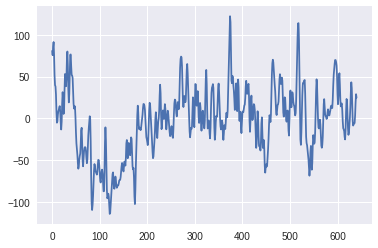

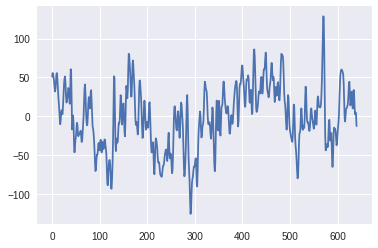

In [5]:
import matplotlib.pyplot as plt
import seaborn
%matplotlib inline
plt.figure(0)
plt.plot(X_crop[0,0,:])
plt.figure(1)
plt.plot(X_crop[3,0,:])

In [6]:
subject_id = 1
filter=[0.5, 36]
t = [0, 4.0]
event_codes = [6,10,14]
physionet_paths = mne.datasets.eegbci.load_data(subject_id, event_codes)
parts = [mne.io.read_raw_edf(path, preload=True,stim_channel='auto', verbose='WARNING')
         for path in physionet_paths]
raw = concatenate_raws(parts)
if filter != None:
    raw.filter(filter[0], filter[1], fir_design='firwin', skip_by_annotation='edge')
else:
    pass
events = mne.find_events(raw, shortest_event=0, stim_channel='STI 014')
eeg_channel_inds = mne.pick_types(raw.info, meg=False, eeg=True, stim=False, eog=False,
                   exclude='bads')
epochs = mne.Epochs(raw, events, dict(hands=2, feet=3), tmin=t[0], tmax=t[1], proj=False, picks=eeg_channel_inds,
                baseline=None, preload=True)

Removing orphaned offset at the beginning of the file.
89 events found
Events id: [1 2 3]
45 matching events found
Not setting metadata
Loading data for 45 events and 641 original time points ...
0 bad epochs dropped


In [7]:
epoch_1 = epochs.copy().crop(tmin=0,tmax=1)
epoch_2 = epochs.copy().crop(tmin=1,tmax=2)

In [8]:
x1 = (epoch_1.get_data()*1e6).astype(np.float32)
x2 = (epoch_2.get_data()*1e6).astype(np.float32)
y1 = (epoch_1.events[:,2]-2).astype(np.int64)
y2 = (epoch_2.events[:,2]-2).astype(np.int64)

In [9]:
print(y1)
print(y2)

[1 0 0 1 0 1 1 0 0 1 1 0 0 1 1 0 1 1 0 1 0 0 1 1 0 0 1 1 0 1 1 0 1 0 0 1 0
 1 0 1 1 0 1 0 1]
[1 0 0 1 0 1 1 0 0 1 1 0 0 1 1 0 1 1 0 1 0 0 1 1 0 0 1 1 0 1 1 0 1 0 0 1 0
 1 0 1 1 0 1 0 1]


In [41]:
time_window = 1.0
time_step = 0.5
epochs_list = []
start = t[0]
end = start + time_window

this_epoch = epochs.copy().crop(tmin=start, tmax=end)
x = (this_epoch.get_data()*1e6).astype(np.float32)
y = (this_epoch.events[:,2]-2).astype(np.int64)  
print('get_time {} to {}'.format(start, end))

while True:
    start += time_step
    end = start + time_window
    if end > t[1]:
        break
#     epochs_list.append(epochs.copy().crop(tmin=start, tmax=end))
    this_epoch = epochs.copy().crop(tmin=start, tmax=end)
    x = np.vstack((x, (this_epoch.get_data()*1e6).astype(np.float32)))
    y = np.hstack((y, (this_epoch.events[:,2]-2).astype(np.int64)))   
    print('get_time {} to {}'.format(start, end))
    
    print(x.shape)
    print(y.shape)

get_time 0 to 1.0
get_time 0.5 to 1.5
(90, 64, 161)
(90,)
get_time 1.0 to 2.0
(135, 64, 161)
(135,)
get_time 1.5 to 2.5
(180, 64, 161)
(180,)
get_time 2.0 to 3.0
(225, 64, 161)
(225,)
get_time 2.5 to 3.5
(270, 64, 161)
(270,)
get_time 3.0 to 4.0
(315, 64, 161)
(315,)


In [27]:
X1, y1 = get_data(id=1, event_code=[4,8,12], filter=[0.5, 36], t=[1, 4.1])
X2, y2 = get_data(id=1, event_code=[6,10,14], filter=[0.5, 36], t=[1, 4.1])

Removing orphaned offset at the beginning of the file.
89 events found
Events id: [1 2 3]
45 matching events found
Not setting metadata
Loading data for 45 events and 497 original time points ...
0 bad epochs dropped
Removing orphaned offset at the beginning of the file.
89 events found
Events id: [1 2 3]
45 matching events found
Not setting metadata
Loading data for 45 events and 497 original time points ...
0 bad epochs dropped


In [28]:
X = np.vstack((X1,X2))
y = np.hstack((y1,y2+2))

In [29]:
y

array([1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1,
       1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 3,
       2, 2, 3, 2, 3, 3, 2, 2, 3, 3, 2, 2, 3, 3, 2, 3, 3, 2, 3, 2, 2, 3, 3,
       2, 2, 3, 3, 2, 3, 3, 2, 3, 2, 2, 3, 2, 3, 2, 3, 3, 2, 3, 2, 3])

TypeError: object of type 'NoneType' has no len()

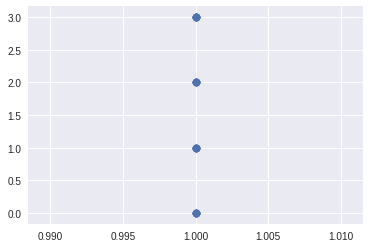

In [40]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
x = [1]*len(y)
plt.scatter(x,y)